<a href="https://colab.research.google.com/github/Saketd3769/Competitive-programming/blob/main/cv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Importing all the packages
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
from google.colab.patches import cv2_imshow    
from skimage import io
from PIL import Image
import matplotlib.pylab as plt

In [ ]:
"""
This module finds the solution of a given sudoku problem
Code credits: Tim Ruscica
More info: https://techwithtim.net/tutorials/python-programming/sudoku-solver-backtracking/
Example input board
board = [
    [7,8,0,4,0,0,1,2,0],
    [6,0,0,0,7,5,0,0,9],
    [0,0,0,6,0,1,0,7,8],
    [0,0,7,0,4,0,2,6,0],
    [0,0,1,0,5,0,9,3,0],
    [9,0,4,0,6,0,0,0,5],
    [0,7,0,3,0,0,0,1,2],
    [1,2,0,0,0,7,4,0,0],
    [0,4,9,2,0,6,0,0,7]
]
"""
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None

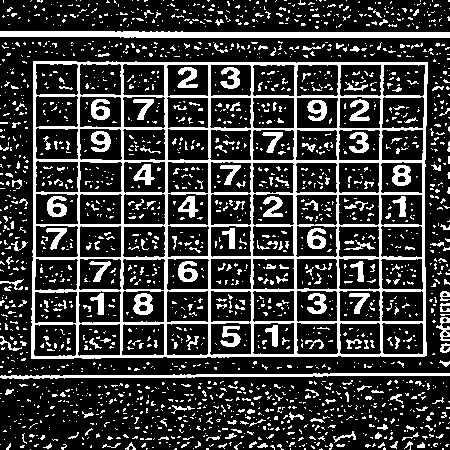

In [ ]:
### Reading and preparing Image ###
path = "/content/sudoku1.jpg"
height=450
width=450
img = io.imread(path) #read the image
img=cv.resize(img,(height,width)) #resize the image
imgGray=cv.cvtColor(img, cv.COLOR_BGR2GRAY) #turn it into grascale
imgBlur=cv.GaussianBlur(imgGray,(5,5),1) #reduce image noise and details.
imgThreshold=cv.adaptiveThreshold(imgBlur,255,1,1,11,2) #to extract those pixels from some image which represent an 
                                                        #object (either text or other line image data such as graphs, maps)
cv2_imshow(imgThreshold)

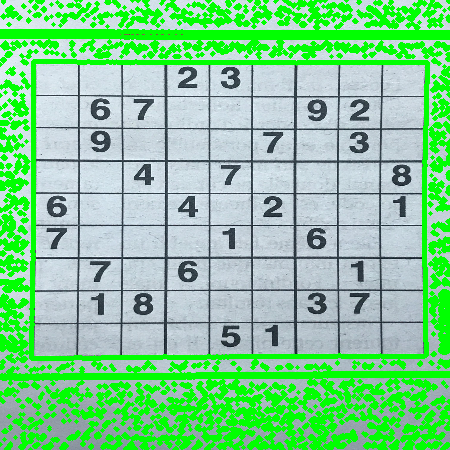

In [ ]:
### Finding the contours ###
imgContours=img.copy()
imgBigContour=img.copy()
contours, hierarchy = cv.findContours(imgThreshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(imgContours, contours, -1, (1, 255, 1), 3)
cv2_imshow(imgContours)

In [ ]:
### Finding the biggest box present
biggest = np.array([])
max_area = 0
for i in contours:
    area = cv.contourArea(i)
    if area > 50:
        peri = cv.arcLength(i, True)
        approx = cv.approxPolyDP(i, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
            biggest = approx
            max_area = area

# cv.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 25)
# cv2_imshow(img)

In [ ]:
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

In [ ]:
print(biggest)
imgBlank=np.zeros((512, 512, 1), dtype = "uint8")
if biggest.size != 0:
    biggest = reorder(biggest)
    print(biggest)
    cv.drawContours(imgBigContour, biggest, -1, (0, 0, 255), 25) # DRAW THE BIGGEST CONTOUR
    pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
    pts2 = np.float32([[0, 0],[width, 0], [0, height],[width, height]]) # PREPARE POINTS FOR WARP
    matrix = cv.getPerspectiveTransform(pts1, pts2) # GER
    imgWarpColored = cv.warpPerspective(img, matrix, (width, height))
    imgDetectedDigits = imgBlank.copy()
    imgWarpColored = cv.cvtColor(imgWarpColored,cv.COLOR_BGR2GRAY)

[[[ 33  61]]

 [[ 31 358]]

 [[426 355]]

 [[427  62]]]
[[[ 33  61]]

 [[427  62]]

 [[ 31 358]]

 [[426 355]]]


In [ ]:
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [ ]:
boxes = splitBoxes(imgWarpColored)
print(len(boxes))

81


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/model.h5')

def getPredection(boxes,model):
    result = []
    i=0
    for image in boxes:
        ## PREPARE IMAGE
        # cv2_imshow(image)
        if i==44:
          cv2_imshow(image)
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv.resize(img, (28, 28))
        img = img.astype('float') / 255.0
        img = img.reshape(1, 28, 28, 1)
        ## GET PREDICTION
        #img2=img.reshape(-1,784)
        #img2=tf.convert_to_tensor(img2,dtype=tf.float32)
        predictions = model.predict(img)
        if i==44:
          print(predictions)
        classIndex = model.predict_classes(img)
        # print(classIndex)
        probabilityValue = np.amax(predictions)
        ## SAVE TO RESULT
        if probabilityValue > 0.8:
            result.append(classIndex[0])
        else:
            result.append(0)
        i+=1
    return result

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


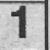

[[0.10228845 0.10595988 0.09493331 0.09886617 0.10297946 0.10150981
  0.09740802 0.09770343 0.10391401 0.09443743]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
numbers = getPredection(boxes,model)
print(numbers)

In [ ]:
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv.LINE_AA)
    return img


In [ ]:
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv.line(img, pt1, pt2, (255, 255, 0),2)
        cv.line(img, pt3, pt4, (255, 255, 0),2)
    return img

In [ ]:
def stackImages(imgArray,scale):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv.cvtColor( imgArray[x][y], cv.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv.cvtColor(imgArray[x], cv.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    return ver

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0])]
[array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4, 5, 6, 7, 8, 9, 1, 2, 3]), array([7, 8, 9, 1, 2, 3, 4, 5, 6]), array([2, 1, 4, 3, 6, 5, 8, 9, 7]), array([3, 6, 5, 8, 9, 7, 2, 1, 4]), array([8, 9, 7, 2, 1, 4, 3, 6, 5]), array([5, 3, 1, 6, 4, 2, 9, 7, 8]), array([6, 4, 2, 9, 7, 8, 5, 3, 1]), array([9, 7, 8, 5, 3, 1, 6, 4, 2])]


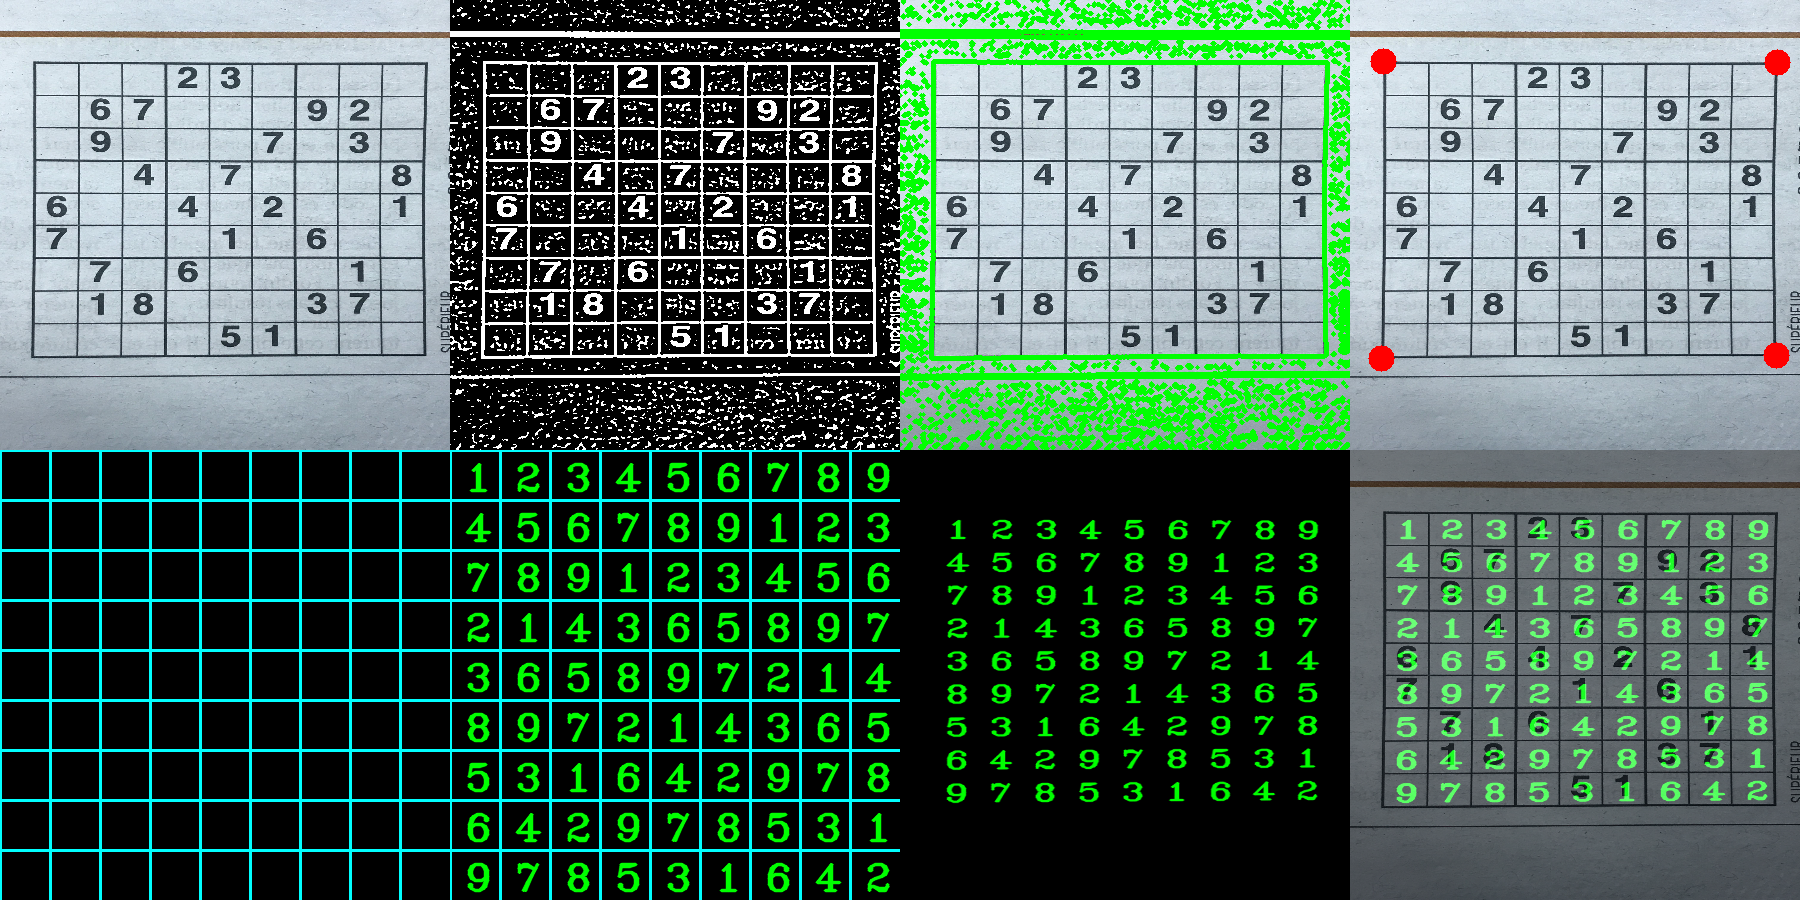

In [ ]:
imgBlank = np.zeros((height, width, 3), np.uint8)
imgDetectedDigits = imgBlank.copy()
imgSolvedDigits = imgBlank.copy()
imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, color=(255, 0, 255))
numbers = np.asarray(numbers)
posArray = np.where(numbers > 0, 0, 1)
print(posArray)


    #### 5. FIND SOLUTION OF THE BOARD
board = np.array_split(numbers,9)
print(board)
try:
    solve(board)
except:
    pass
print(board)
flatList = []
for sublist in board:
    for item in sublist:
        flatList.append(item)
solvedNumbers =flatList*posArray
imgSolvedDigits= displayNumbers(imgSolvedDigits,solvedNumbers)

    # #### 6. OVERLAY SOLUTION
pts2 = np.float32(biggest) # PREPARE POINTS FOR WARP
pts1 =  np.float32([[0, 0],[width, 0], [0, height],[width, height]]) # PREPARE POINTS FOR WARP
matrix = cv.getPerspectiveTransform(pts1, pts2)  # GER
imgInvWarpColored = img.copy()
imgInvWarpColored = cv.warpPerspective(imgSolvedDigits, matrix, (width, height))
inv_perspective = cv.addWeighted(imgInvWarpColored, 1, img, 0.5, 1)
imgDetectedDigits = drawGrid(imgDetectedDigits)
imgSolvedDigits = drawGrid(imgSolvedDigits)

imageArray = ([img,imgThreshold,imgContours, imgBigContour],
                  [imgDetectedDigits, imgSolvedDigits,imgInvWarpColored,inv_perspective])
stackedImage = stackImages(imageArray, 1)
cv2_imshow(stackedImage)
